# Homework 7

## APMTH 207: Stochastic Methods for Data Analysis, Inference and Optimization

**Due Date: ** Friday, March 23rd, 2018 at 11:00am

**Instructions:**

- Upload your final answers as a Jupyter notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

## Problem 1: Gibbs Sampling On A Bivariate Normal

Let $\mathbf{X}$ be a random variable taking values in $\mathbb{R}^2$. That is, $\mathbf{X}$ is a 2-dimensional vector. Suppose that $\mathbf{X}$ is normally distributed as follows
$$ 
\mathbf{X} \sim \mathcal{N} \left(  
\left[
\begin{array}{c}
    1  \\ 
    2  \\ 
  \end{array} 
\right],
\left[
  \begin{array}{ccc}
    4 & 1.2  \\ 
    1.2 & 4 \\ 
  \end{array} 
  \right] \right).
$$ 
That is, the pdf of the distribution of $\mathbf{X}$ is
$$
f_{\mathbf{X}}(\mathbf{x}) = \frac{1}{2\pi\sqrt{\vert \Sigma\vert }}\mathrm{exp}\left\{ - \frac{1}{2} (\mathbf{x} - \mu)^\top \Sigma^{-1} (\mathbf{x} - \mu)\right\}
$$
where $\mu = \left[
\begin{array}{c}
    1  \\ 
    2  \\ 
  \end{array} 
\right]$, $\Sigma = \left[
  \begin{array}{ccc}
    4 & 1.2  \\ 
    1.2 & 4 \\ 
  \end{array} 
  \right]$, and $\vert \cdot\vert $ is the matrix determinant operator.

In the following, we will denote the random variable corresponding to the first component of $\mathbf{X}$ by $X_1$ and the second component by $X_2$.

* Write a Gibbs sampler for this distribution by sampling sequentially from the two conditional distributions $f_{X_1\vert X_2}, f_{X_2\vert X_1}$. 
* Choose a thinning parameter, burn-in factor and total number of iterations that allow you to take 10000 non-autocorrelated draws. 
* You must justify your choice of parameters. 

***

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pymc3 as pm
from pymc3 import traceplot
from pymc3 import autocorrplot
from pymc3 import gelman_rubin
from pymc3 import geweke  
from pymc3 import forestplot

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
C:\Users\Shaan Desai\Anaconda3\envs\am207\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### Question 1.1

Lets define all the variables we plan to use:

mu1 = 1

mu2 = 2

sigmax1 = 2

sigmax2 = 2

$rho*sigmax1*sigmax2$ = 1.2

rho = 1.2/4 = 0.3

The conditionals depend on these variables (https://en.wikipedia.org/wiki/Normal_distribution) s.t.:

$$ X1|X2=x2  \sim N(\mu_{x1} + (\sigma_{x1}/\sigma_{x2})*\rho*(x_2-\mu_2), (1-\rho^2)\sigma_{x1}^2) $$

$$ X2|X1=x1  \sim N(\mu_{x2} + (\sigma_{x2}/\sigma_{x1})*\rho*(x_1-\mu_1), (1-\rho^2)\sigma_{x2}^2) $$


In [2]:
#gibbs sampler variables
N = 10000
x1all=np.zeros(N+1)
x2all=np.zeros(N+1)
#Initialize x1 and x2
x1all[0]=1.
x2all[0]=2.
sigmax1 = 2.
sigmax2 = 2.
rho = 0.3
mux1 = 1.
mux2 = 2.

sig = lambda p,sval: np.sqrt((1-p**2)*sval**2)
mu = lambda me1,me2,z,i: me1 + 1*rho*(z[i]-me2)

for i in range(1,N,2):
    sig_x1 = sig(rho,sigmax1)
    mu_x1 = mu(mux1,mux2,x2all,i-1)
    x1all[i] = np.random.normal(mu_x1, sig_x1)
    x2all[i] = x2all[i-1]
    
    sig_x2 = sig(rho,sigmax2)
    mu_x2 = mu(mux2,mux1,x1all, i)
    x2all[i+1] = np.random.normal(mu_x2, sig_x2)
    x1all[i+1] = x1all[i]

Trace plot gives a sense of the autocorrelation. We can plot this for both the variables.

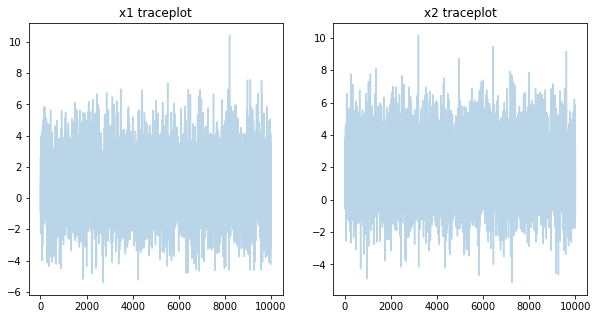

In [3]:
fig,ax = plt.subplots(1,2,figsize=(10,5));
ax[0].plot(x1all,alpha=.3);
ax[0].set_title('x1 traceplot');
ax[1].plot(x2all,alpha=.3);
ax[1].set_title('x2 traceplot');


We can also plot the marginals


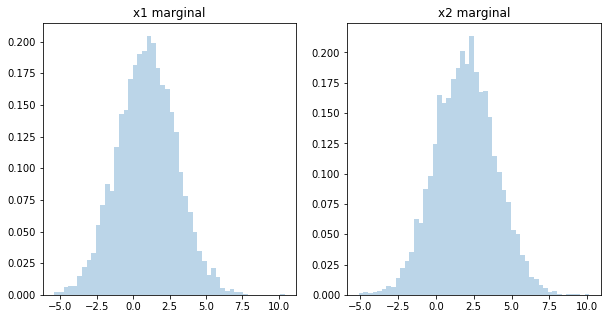

In [4]:
fig,ax = plt.subplots(1,2,figsize=(10,5));
ax[0].hist(x1all,bins=50,density=True,alpha=.3);
ax[0].set_title('x1 marginal');
ax[1].hist(x2all,bins=50,density=True,alpha=.3);
ax[1].set_title('x2 marginal');


Text(0.5,1,'Contour plot with samples')

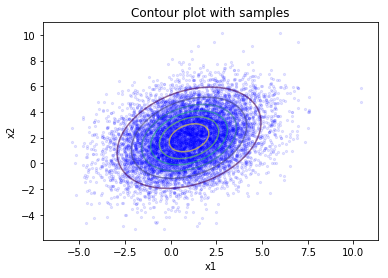

In [5]:
#movements
from scipy.stats import multivariate_normal
def f(x,y):
    return multivariate_normal.pdf([x,y],mean=[mux1,mux2],cov = [[sigmax1**2,1.2],[1.2,sigmax2**2]])
   
xx=np.linspace(-7,7,300)
yy=np.linspace(-5,7,300)
zz = []
xg,yg = np.meshgrid(xx,yy)
for i in range(len(xx)):
    for j in range(len(yy)):
        zz.append(f(xx[i],yy[j]))
        
zz = np.array(zz)
zz = zz.reshape(xg.shape).T

plt.figure()
plt.contour(xg,yg,zz, alpha=0.6)
plt.scatter(x1all,x2all, alpha=0.1, c='b', s=5)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Contour plot with samples')

In [29]:
def corrplot(trace,ax, maxlags=50):
    ax.acorr(trace-np.mean(trace),  normed=True, maxlags=maxlags);
    ax.set_xlim([0, maxlags])

Text(0.5,1,'Correlation of X2')

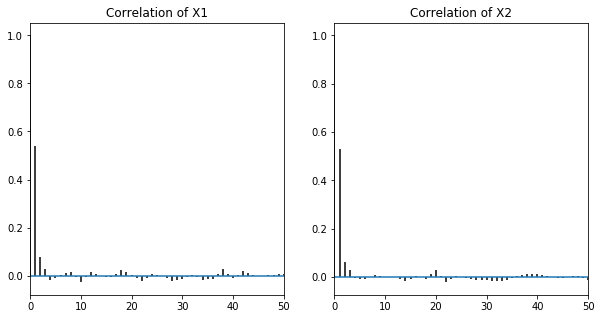

In [31]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
corrplot(x1all[N//10:],ax[0])
corrplot(x2all[N//10:],ax[1])
ax[0].set_title('Correlation of X1')
ax[1].set_title('Correlation of X2')

#### Question 1.2

So we can see that there is some correlation even after burnin. We can obviously use some thinning. One way to test for the best number of effective samples is to use the function presented in lab.

In [34]:
def effectiveSampleSize(data, stepSize = 1):
    samples = len(data)

    assert len(data) > 1,"no stats for short sequences"
  
    maxLag = min(samples//3, 1000)

    gammaStat = [0,]*maxLag
    #varGammaStat = [0,]*maxLag

    varStat = 0.0;

    if type(data) != np.ndarray:
        data = np.array(data)

    normalizedData = data - data.mean()

    for lag in range(maxLag):
        v1 = normalizedData[:samples-lag]
        v2 = normalizedData[lag:]
        v = v1 * v2
        gammaStat[lag] = sum(v) / len(v)
        #varGammaStat[lag] = sum(v*v) / len(v)
    #varGammaStat[lag] -= gammaStat[0] ** 2

    # print lag, gammaStat[lag], varGammaStat[lag]

        if lag == 0:
            varStat = gammaStat[0]
        elif lag % 2 == 0:
            s = gammaStat[lag-1] + gammaStat[lag]
            if s > 0:
                varStat += 2.0*s
            else:
                break

    # standard error of mean
    # stdErrorOfMean = Math.sqrt(varStat/samples);

    # auto correlation time
    act = stepSize * varStat / gammaStat[0]

    # effective sample size
    ess = (stepSize * samples) / act

    return ess

In [35]:
#make sampler a function (gibbs sampler)
def gibbs(nsamps):
    N = nsamps
    x1all=np.zeros(N+1)
    x2all=np.zeros(N+1)
    #Initialize x1 and x2
    x1all[0]=1.
    x2all[0]=2.
    sigmax1 = 2.
    sigmax2 = 2.
    rho = 0.3
    mux1 = 1.
    mux2 = 2.

    sig = lambda p,sval: np.sqrt((1-p**2)*sval**2)
    mu = lambda me1,me2,z,i: me1 + 1*rho*(z[i]-me2)

    for i in range(1,N,2):
        sig_x1 = sig(rho,sigmax1)
        mu_x1 = mu(mux1,mux2,x2all,i-1)
        x1all[i] = np.random.normal(mu_x1, sig_x1)
        x2all[i] = x2all[i-1]

        sig_x2 = sig(rho,sigmax2)
        mu_x2 = mu(mux2,mux1,x1all, i)
        x2all[i+1] = np.random.normal(mu_x2, sig_x2)
        x1all[i+1] = x1all[i]
    return x1all,x2all

One way to quickly determine the best thinning and burnin parameters is to loop over a range of them and determine the effective sample size. Once we have this, we can look at autocorrelation plots.

In [41]:
import pandas as pd
df = pd.DataFrame(columns=['initial # of samples','thinning rate','burnin','effective_x1','effective_x2'])
nsamps = [12000,15000,20000,25000]
thinningr = [2,5,10]
burnin = [1000,2500,5000]
for ns in range(len(nsamps)):
    for tr in range(len(thinningr)):
        for b in range(len(burnin)):
            x1,x2 = gibbs(nsamps[ns])
            xtmp1 = x1[burnin[b]::thinningr[tr]]
            xtmp2 = x2[burnin[b]::thinningr[tr]]
            esx = effectiveSampleSize(xtmp1)
            esy = effectiveSampleSize(xtmp2)
            df.loc[len(df)]=[nsamps[ns],thinningr[tr],burnin[b],esx,esy]
#             print('initial samples = ' + str(nsamps[ns]) +',thinning = '+str(thinningr[tr])+',burnin = '+str(burnin[b]),',effective samples x1 = ' +str(esx),',effective samples x2 = ' +str(esy))


In [42]:
df

,initial # of samples,thinning rate,burnin,effective_x1,effective_x2
0,12000.0,2.0,1000.0,4375.627092,5043.206026
1,12000.0,2.0,2500.0,3950.285339,3857.918353
2,12000.0,2.0,5000.0,2603.197542,2764.584765
3,12000.0,5.0,1000.0,2047.166672,1987.445389
4,12000.0,5.0,2500.0,1757.244746,1901.000000
5,12000.0,5.0,5000.0,1168.363939,1286.609128
6,12000.0,10.0,1000.0,1101.000000,1008.122277
7,12000.0,10.0,2500.0,951.000000,951.000000
8,12000.0,10.0,5000.0,629.189105,701.000000
9,15000.0,2.0,1000.0,5881.379122,5985.889672


From the results above, row 27 suggests that we get effective sample sizes of 10,000 when we use an initial sample size of 25,000 with a thinning rate of 2 and a burnin of 1000.

We can look at the autocorrelation plots of these particular parameters to make sure.

Text(0.5,1,'Correlation of X2')

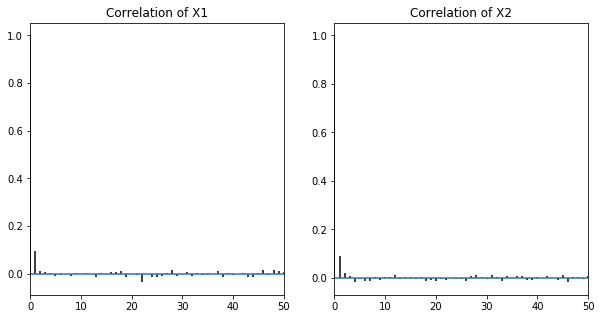

In [44]:
x1,x2 = gibbs(25000)
xtmp1 = x1[1000::2]
xtmp2 = x2[1000::2]
fig,ax = plt.subplots(1,2,figsize=(10,5))
corrplot(xtmp1,ax[0])
corrplot(xtmp2,ax[1])
ax[0].set_title('Correlation of X1')
ax[1].set_title('Correlation of X2')

Now we are confident that our samples are not autocorrelated.

## Problem 2: Rubber Chickens Bawk Bawk!
In the competitive rubber chicken retail market, the success of a company is built on satisfying the exacting standards of a consumer base with refined and discriminating taste. In particular, customer product reviews are all important. But how should we judge the quality of a product based on customer reviews?

On Amazon, the first customer review statistic displayed for a product is the ***average rating***. The following are the main product pages for two competing rubber chicken products, manufactured by Lotus World and Toysmith respectively:


Lotus World |  Toysmith
- |  - 
![alt](https://am207.github.io/2018spring/homework/lotus1.png) |  ![alt](https://am207.github.io/2018spring/homework/toysmith1.png)

Clicking on the 'customer review' link on the product pages takes us to a detailed break-down of the reviews. In particular, we can now see the number of times a product is rated a given rating (between 1 and 5 stars).

Lotus World |  Toysmith
- |  - 
![alt](https://am207.github.io/2018spring/homework/lotus2.png) |  ![alt](https://am207.github.io/2018spring/homework/toysmith2.png)

(The images above are also included on canvas in case you are offline, see below)

In the following, we will ask you to compare these two products using the various rating statistics. **Larger versions of the images are available in the data set accompanying this notebook**.

Suppose that for each product, we can model the probability of the value each new rating as the following vector:
$$
\theta = [\theta_1, \theta_2, \theta_3, \theta_4, \theta_5]
$$
where $\theta_i$ is the probability that a given customer will give the product $i$ number of stars.


### Part A: Inference

1. Suppose you are told that customer opinions are very polarized in the retail world of rubber chickens, that is, most reviews will be 5 stars or 1 stars (with little middle ground). Choose an appropriate Dirichlet prior for $\theta$. Recall that the Dirichlet pdf is given by:
$$
f_{\Theta}(\theta) = \frac{1}{B(\alpha)} \prod_{i=1}^k \theta_i^{\alpha_i - 1}, \quad B(\alpha) = \frac{\prod_{i=1}^k\Gamma(\alpha_i)}{\Gamma\left(\sum_{i=1}^k\alpha_i\right)},
$$
where $\theta_i \in (0, 1)$ and $\sum_{i=1}^k \theta_i = 1$, $\alpha_i > 0 $ for $i = 1, \ldots, k$.

2. Write an expression for the posterior pdf, using a using a multinomial model for observed ratings. Recall that the multinomial pdf is given by:
$$
f_{\mathbf{X}\vert  \Theta}(\mathbf{x}) = \frac{n!}{x_1! \ldots x_k!} \theta_1^{x_1} \ldots \theta_k^{x_k}
$$
where $n$ is the total number of trials, $\theta_i$ is the probability of event $i$ and $\sum_i \theta_i = 1$, and $x_i$ is count of outcome $i$ and $\sum_i x_i = n$. 

  **Note:** The data you will need in order to define the likelihood function should be read off the image files included in the dataset.
  

3. Sample 1,000 values of $\theta$ from the *posterior distribution*.
 
4. Sample 1,000 values of $x$ from the *posterior predictive distribution*.


### Part B: Ranking

1. Name at least two major potential problems with using only the average customer ratings to compare products.

  (**Hint:** if product 1 has a higher average rating than product 2, can we conclude that product 1 is better liked? If product 1 and product 2 have the same average rating, can we conclude that they are equally good?)
  

2. Using the samples from your *posterior distribution*, determine which rubber chicken product is superior. Justify your conclusion with sample statistics.

3. Using the samples from your *posterior predictive distribution*, determine which rubber chicken product is superior. Justify your conclusion with sample statistics.

4. Finally, which rubber chicken product is superior?

  (**Note:** we're not looking for "the correct answer" here, any sound decision based on a statistically correct interpretation of your model will be fine)

****

Answers

#### Part A

1.Since the customers are polarized between 1 and 5, we need to simply set larger alphas at these two end points. The other values can be set to the same value since we don't have any prior knowledge about them.

As such I choose $$ \alpha = [2,1,1,1,2] $$

2.Since we are given a multinomial for our likelihood, we have dirichlet-multinomial conjugacy. As such, the posterior distribution is:

$$ P(\theta|X) = \prod_{j=1}^{5}p_j^{\alpha_j-1 + \sum_{y}y_i^j} $$



### Note: model 1 is Lotus World and model 2 is toysmith

In [29]:
with pm.Model() as model1:
    theta_prior = pm.Dirichlet('theta_prior',a=np.array([10,1,1,1,10]))#parameter's prior
    likelihood = pm.Multinomial('likelihood', p=theta_prior, n=162,observed=np.array([10,6,10,28,108]))#likelihood
    stepper = pm.NUTS()
    tracemodel1=pm.sample(10000, step=stepper,start=[{'theta_prior':np.array([0.4,0.1,0.1,0.1,0.3])},{'theta_prior':np.array([0.3,0.1,0.2,0.1,0.3])}])


C:\Users\Shaan Desai\Anaconda3\envs\am207\lib\site-packages\theano\tensor\basic.py:2184: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"
C:\Users\Shaan Desai\Anaconda3\envs\am207\lib\site-packages\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta_prior_stickbreaking__]


In [30]:
with pm.Model() as model2:
    theta_prior = pm.Dirichlet('theta_prior',a=np.array([10,1,1,1,10]))#parameter's prior
    likelihood = pm.Multinomial('likelihood', p=theta_prior, n=410,observed=np.array([57,33,29,45,246]))#likelihood
    stepper=pm.NUTS()
    tracemodel2=pm.sample(10000, step=stepper,start=[{'theta_prior':np.array([0.4,0.1,0.1,0.1,0.3])},{'theta_prior':np.array([0.3,0.1,0.2,0.1,0.3])}])

C:\Users\Shaan Desai\Anaconda3\envs\am207\lib\site-packages\theano\tensor\basic.py:2184: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"
C:\Users\Shaan Desai\Anaconda3\envs\am207\lib\site-packages\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta_prior_stickbreaking__]


With 10000 samples in each, I use a burnin of 2000 and a thinning rate of 8 to get our 1000 samples.

Model 1 Traceplot

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E2D2135668>,
      dtype=object)

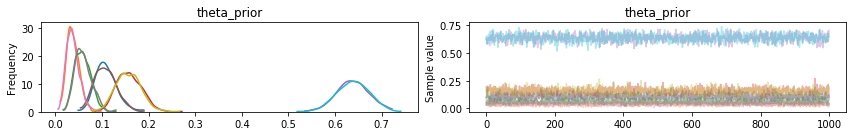

In [31]:
burnin = 2000
thin = 8
traceplot(tracemodel1[burnin::thin])

Model 2 Traceplot

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E2CFB12B70>,
      dtype=object)

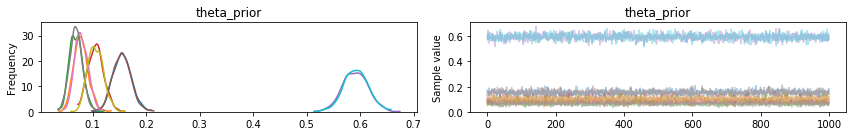

In [32]:
traceplot(tracemodel2[burnin::thin])

Now, we can use these samples to get the posterior predictive!

In [33]:
postpred_m1 = pm.sample_ppc(tracemodel1[burnin::thin], 1000, model1)
postpred_m2 = pm.sample_ppc(tracemodel2[burnin::thin], 1000, model2)

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2379.66it/s]


In [34]:
model1.observed_RVs

[likelihood]

#### Part B

##### Question 1
One problem with using the average customer rating is skewness. For example, if the average of 1 product is higher, this may be because there are numerous outliers pulling the score up and vice-versa for a product that is lower. Another problem is sample size. For example, one rubber duck company could be relatively new in the market with only a few reviews and an average rating comparable to an item that has been on the market for years. As a consequence, we could jump to say they are the same quality however, it is very likely that the older company has better industry knowledge and a wider product offering. Also, I wanted to add that often times there are fake reviews which can skew the ratings too.

##### Question 2

We can look at the posterior distribution samples of theta which capture the probabilities of getting a particular rating given the data. If we look at the MAP of each of the theta_i's we can get a sense of the mode value of each probability and hence a better sense of which duck company receives higher probabilities of 4's and 5's with the data present.

Distribution of ratings probabilities for model 1

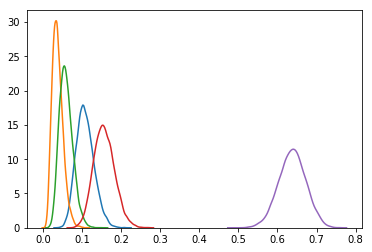

In [35]:
import seaborn as sns
for i in range(5):
    sns.kdeplot(tracemodel1['theta_prior'][:,i])
        

Distribution of ratings probabilities for model 2

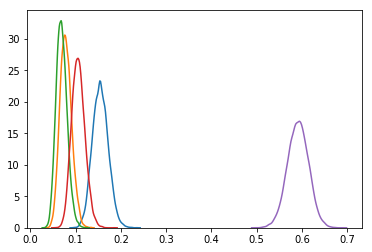

In [36]:
import seaborn as sns
for i in range(5):
    sns.kdeplot(tracemodel2['theta_prior'][:,i])
        

From the figures above we can see the probabilities of ratings 5 through 1, 5 being in blue. One potential metric is to simply compare the mean of the distribution of probabilities with a rating of 5.

In [39]:
print('mean of model 1 theta_5 = %s' %np.mean(tracemodel1['theta_prior'][:,4]))
print('std = %s' %np.std(tracemodel1['theta_prior'][:,4]))

mean of model 1 theta_5 = 0.6376909664816285
std = 0.03491716469987493


In [40]:
print('mean of model 2 theta_5= %s' %np.mean(tracemodel2['theta_prior'][:,4]))
print('std = %s' %np.std(tracemodel2['theta_prior'][:,4]))

mean of model 2 theta_5= 0.5912392947725568
std = 0.023230375875290598


From this one can conclude that duck company 1 is better since the probability of receiving a 5 given it's data is higher than that of company 2. However, this does not account for other ratings and is only 1 metric. Another metric could be to multiply the means of each theta distribution by their respective rating. This way, we can weight the importance of a 5 rating.

##### Weighting of Company 1 and Company 2 mean probabiities with highest scores being most important.

In [44]:
np.sum(np.mean(tracemodel1['theta_prior'][:,:],axis=0)*[1,2,3,4,5])

4.178297856439962

In [45]:
np.sum(np.mean(tracemodel2['theta_prior'][:,:],axis=0)*[1,2,3,4,5])

3.9003526777587467

Using the weighted metric, we still get company 1 being better. We can also do the opposite weighting in which a 1 star is given the most weight.

##### Weighting of Company 1 and Company 2 mean probabiities with lowest scores being most important.

In [46]:
np.sum(np.mean(tracemodel1['theta_prior'][:,:],axis=0)*[5,4,3,2,1])

1.8217021435600242

In [48]:
np.sum(np.mean(tracemodel2['theta_prior'][:,:],axis=0)*[5,4,3,2,1])

2.0996473222412706

Here again, we see that even though we weight the lower ratings higher, company 1 has a lower score which indicates its low ratings aren't as bad as company 2.

##### Question 3 
We can do something similar to the above case except using the samples from the posterior predictive.


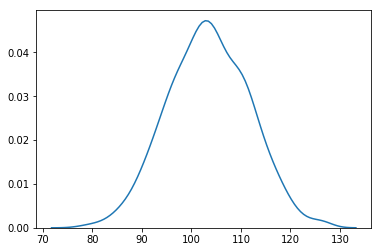

In [54]:
sns.kdeplot(postpred_m1['likelihood'][:,4])

In [55]:
print('mean = %s' %np.mean(postpred_m1['likelihood'][:,4]))
print('std = %s' %np.std(postpred_m1['likelihood'][:,4]))

mean = 103.473
std = 8.23815944249685


In [68]:
print('probability of 5 star rating = %s' %(103.4/162))

probability of 5 star rating = 0.6382716049382716


In [63]:
pm.hpd(postpred_m1['likelihood'])

array([[  8.,  27.],
       [  0.,  12.],
       [  2.,  17.],
       [ 15.,  38.],
       [ 88., 119.]])

In [65]:
print('width of hpd for 5star rating = %s' %(119-88))

width of hpd for 5star rating = 31


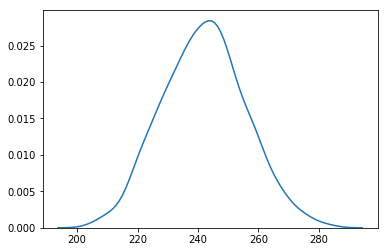

In [56]:
sns.kdeplot(postpred_m2['likelihood'][:,4])

In [58]:
print('mean = %s' %np.mean(postpred_m2['likelihood'][:,4]))
print('std = %s' %np.std(postpred_m2['likelihood'][:,4]))

mean = 241.986
std = 13.71458362474049


In [69]:
print('probability of 5 star rating = %s' %(241.98/410))

probability of 5 star rating = 0.5901951219512195


In [66]:
pm.hpd(postpred_m2['likelihood'])

array([[ 43.,  82.],
       [ 16.,  46.],
       [ 15.,  42.],
       [ 28.,  59.],
       [216., 268.]])

In [67]:
print('width of hpd for 5star rating = %s' %(268-216))

width of hpd for 5star rating = 52


From the metrics above we can see that company 1 is better because it has a higher probability of getting a 5 star on average and its hpd credible interval at this rating is lower than that of company 1 meaning we are much more certain about its value (note that this hpd changes with the number of datapoints so it could be that at some point we can make the hpds similar, however, in this case company 2 already has more datapoints and still maintains a higher hpd width).

##### Question 4
I would buy from company 1(lotus world). 

## Problem 3:  Implementing Rat Tumors in pymc3

(it may help to see the bioassay lab to see how to structure pymc3 code, and also the examples from lecture).

Let us try to do full Bayesian inference with PyMC3 for the rat tumor example that we have solved using explicit Gibbs sampling in lab7. Remember that the goal is to estimate $\theta_i$, the probability of developing a tumor in a population of female rats that have not received treatement. 

The posterior for the 70 experiments may be written thus:

$$p( \{\theta_i\}, \alpha, \beta  \vert  Y, \{n_i\}) \propto p(\alpha, \beta) \prod_{i=1}^{70} Beta(\theta_i, \alpha, \beta) \prod_{i=1}^{70} Binom(n_i, y_i, \theta_i)$$

Use uniform priors on $[0,1]$ on the alternative variables $\mu$ (the mean of the beta distribution) and $\nu$:

$$\mu = \frac{\alpha}{\alpha+\beta}, \nu = (\alpha+\beta)^{-1/2}$$

You may then write $\alpha$ and $\beta$ as deterministics which depend on $\mu$ and $\nu$.

Here is the data:

In [2]:
tumordata="""0 20 
0 20 
0 20 
0 20 
0 20 
0 20 
0 20 
0 19 
0 19 
0 19 
0 19 
0 18 
0 18 
0 17 
1 20 
1 20 
1 20 
1 20 
1 19 
1 19 
1 18 
1 18 
3 27 
2 25 
2 24 
2 23 
2 20 
2 20 
2 20 
2 20 
2 20 
2 20 
1 10 
5 49 
2 19 
5 46 
2 17 
7 49 
7 47 
3 20 
3 20 
2 13 
9 48 
10 50 
4 20 
4 20 
4 20 
4 20 
4 20 
4 20 
4 20 
10 48 
4 19 
4 19 
4 19 
5 22 
11 46 
12 49 
5 20 
5 20 
6 23 
5 19 
6 22 
6 20 
6 20 
6 20 
16 52 
15 46 
15 47 
9 24 
"""

In [3]:
tumortuples=[e.strip().split() for e in tumordata.split("\n")]
tumory=np.array([np.int(e[0].strip()) for e in tumortuples if len(e) > 0])
tumorn=np.array([np.int(e[1].strip()) for e in tumortuples if len(e) > 0])
tumory, tumorn

(array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,
         1,  1,  1,  1,  1,  3,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  5,
         2,  5,  2,  7,  7,  3,  3,  2,  9, 10,  4,  4,  4,  4,  4,  4,  4,
        10,  4,  4,  4,  5, 11, 12,  5,  5,  6,  5,  6,  6,  6,  6, 16, 15,
        15,  9]),
 array([20, 20, 20, 20, 20, 20, 20, 19, 19, 19, 19, 18, 18, 17, 20, 20, 20,
        20, 19, 19, 18, 18, 27, 25, 24, 23, 20, 20, 20, 20, 20, 20, 10, 49,
        19, 46, 17, 49, 47, 20, 20, 13, 48, 50, 20, 20, 20, 20, 20, 20, 20,
        48, 19, 19, 19, 22, 46, 49, 20, 20, 23, 19, 22, 20, 20, 20, 52, 46,
        47, 24]))

Some manipulations to determine alpha and beta in terms of alternative variables.
$$\alpha\mu + \beta \mu = a $$
$$ a = -\beta \mu/(\mu-1) $$
$$ v^2 = 1/(\alpha+\beta) $$ 
$$ \alpha+\beta = 1/v^2 $$
$$ \alpha = -\beta +1/v^2 $$
$$-\beta + 1/v^2 = -\beta \mu/(\mu-1) $$
$$ \beta(1-\mu/(\mu-1))=1/v^2 $$
$$ \beta=1/(v^2(1-\mu/(\mu-1))) $$





$$\alpha = 1/v^2 - \beta $$

In [4]:
with pm.Model() as ratumor:
    #parent stochastic hyper-priors
    mu = pm.Uniform('mu',lower=0.0,upper=1.0)
    nu = pm.Uniform('nu',lower=0.0,upper=1.0)
    #dependent children
    beta = pm.Deterministic('beta',var=(1-mu)/nu**2)
    alpha =pm.Deterministic('alpha',var=mu/(nu**2))
    #specify 70 dimensions and 70 theta's
    theta = pm.Beta('theta',alpha = alpha, beta = beta,shape=70)
    likelihood = pm.Binomial('likelihood', p=theta,n=tumorn,observed=tumory)#likelihood
    

In [5]:
with ratumor:  
    # instantiate sampler
    step = pm.NUTS()
    # draw 2000 posterior samples
    rat_trace = pm.sample(10000, step=step,start=[{'mu':np.random.uniform(0,1),'nu':np.random.uniform(0,1)},{'mu':np.random.uniform(0,1),'nu':np.random.uniform(0,1)}])

C:\Users\Shaan Desai\Anaconda3\envs\am207\lib\site-packages\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta_logodds__, nu_interval__, mu_interval__]
The number of effective samples is smaller than 25% for some parameters.


### Part A:  Report at least the following diagostics on your samples

1. Autocorrelation (correlation dying by lag 20 is fine)
2. Parameter trace correlation after burnin
3. Gewecke
4. Gelman-Rubin
5. $n_{eff}$ (Number of Effective Samples)

plotting the trace here just to get a sense of convergence at a higher level

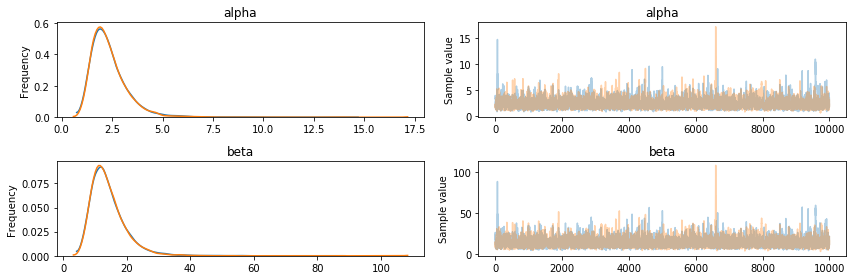

In [6]:
pm.plots.traceplot(rat_trace,varnames =['alpha','beta']);

1. Autocorrelation after burnin of 2000 seems really good!

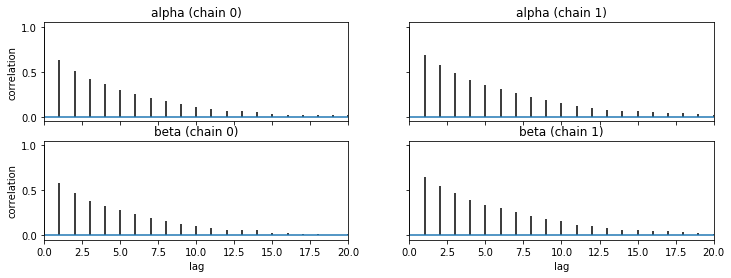

In [7]:
autocorrplot(rat_trace[2000:],max_lag=20,varnames =['alpha','beta']);

\2. alpha beta correlation appears to be quite high

In [8]:
df = pm.trace_to_dataframe(rat_trace[2000:])
df.corr()[['beta','alpha']]

,beta,alpha
mu,-0.148654,0.104162
nu,-0.890631,-0.859327
beta,1.000000,0.963457
alpha,0.963457,1.000000
theta__0,0.246869,0.275224
theta__1,0.244778,0.271151
theta__2,0.250555,0.279535
theta__3,0.247037,0.274544
theta__4,0.257689,0.285473
theta__5,0.234971,0.267384


3.

In [9]:
z = geweke(rat_trace[2000:], intervals=15)

(0, 4000)

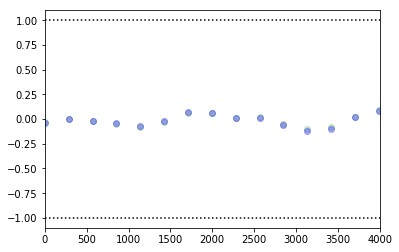

In [10]:
plt.scatter(*z[0]['alpha'].T,c='g',alpha=0.2)
plt.scatter(*z[0]['beta'].T,c='b',alpha=.3)
plt.hlines([-1,1], 0, 4000, linestyles='dotted')
plt.xlim(0, 4000)

\4. Gelman Rubin numbers for alpha and beta are basically 1 which is good!

In [14]:
with ratumor:
    step = pm.NUTS()
    rat_trace1 = pm.sample(10000, njobs=4, step=step, start=[{'mu':np.random.uniform(0,1)}, {'mu':np.random.uniform(0,1)}, {'mu':np.random.uniform(0,1)}, {'mu':np.random.uniform(0,1)}])

C:\Users\Shaan Desai\Anaconda3\envs\am207\lib\site-packages\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_logodds__, nu_interval__, mu_interval__]
The number of effective samples is smaller than 25% for some parameters.


In [16]:
gelman_rubin(rat_trace1[2000:],varnames =['alpha','beta'])

{'alpha': 1.0003504254803186, 'beta': 1.0003445388828467}

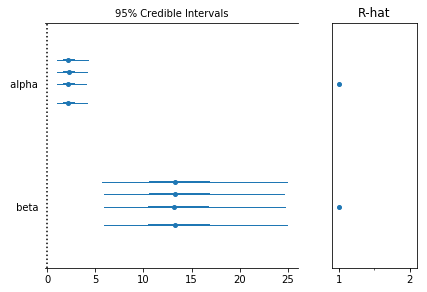

In [17]:
forestplot(rat_trace1,varnames =['alpha','beta'])

5. From the 10,000 samples we see that roughly 25% are effective. This number is quite low indicating the need for some more initial samples as well as thinning and burnin.From the autocorrelation plots we can see that both these will help since by 20lags the correlation is very low. Note: I did not run the sampler again to get a higher number of effective samples because it runs relatively slowly.

In [13]:
pm.effective_n(rat_trace,varnames=['alpha','beta'])

{'alpha': 2356.0, 'beta': 2447.0}

### Part B:  Posterior predictive check

Recall from lab notes that in a hierarchical model there are two kinds of posterior predictions that are useful. (1) The distribution of future observations $y_i^*$  given a $\theta_i$, and (2) The distribution of observations $y_j^*$  drawn from a future $\theta_j$ drawn from the super-population (i.e. using the Beta on the estimated hyper parameters).

1. Carry out posterior predictive checks by using `sample_ppc` to generate posterior-predictives for all 70 experiments. This generates predictives of the first type above. 

2. Plot histograms for these predictives with the actual value shown as a red-dot against the histogram (as in the coal disasters model in lecture 14). Is the data consistent with the predictive?

1.

In [14]:
postpred_rat = pm.sample_ppc(rat_trace[2000:], 1000, ratumor)

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3808.63it/s]


(4,)


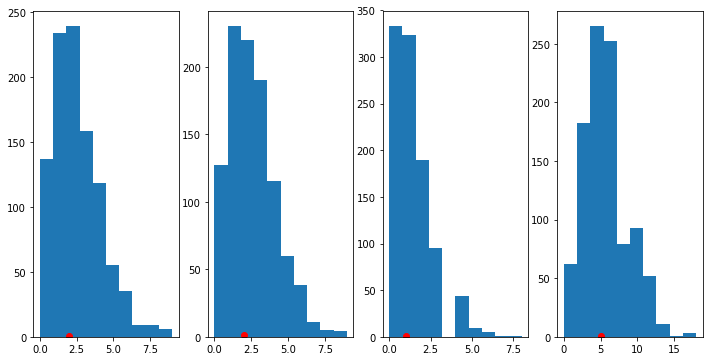

In [15]:
fig, axes = plt.subplots(1, 4, figsize=(12, 6))
print(axes.shape)
for i in range(30,34):
    axes[i-30].hist(postpred_rat['likelihood'][:,i], bins=10)
    axes[i-30].plot(tumory[i],1,'ro')

### Part C:  Shrinkage

1. Plot the posterior median of the death rate parameters $\theta_1, \theta_2, ...\theta_{70}$ against the observed death rates ($y_i/n_i$)

2. Explain the shrinkage by comparing against a 45 degree line as done in the lab.

(-0.1, 0.5)

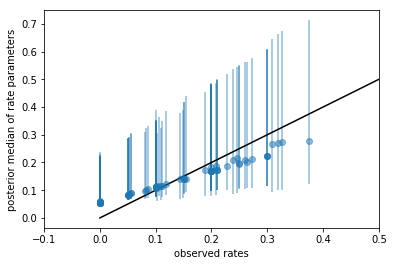

In [17]:
percentiles=np.percentile(rat_trace['theta'][2000:], [2.5,50.0, 97.5], axis=0)
lowerthetas, medianthetas, upperthetas=percentiles

elowertheta = medianthetas - lowerthetas
euppertheta = upperthetas - medianthetas


# medians = np.median(rat_trace['theta'][2000:],axis=0)
drates = tumory/tumorn
plt.errorbar(drates,medianthetas, yerr=[lowerthetas,upperthetas], fmt='o', alpha=0.5)
plt.plot([0,0.5],[0,0.5],'k-')
plt.xlabel("observed rates")
plt.ylabel("posterior median of rate parameters")

plt.xlim(-0.1,0.5)

We can see that by reducing the parameters we get some skew!

### PART D:  Experiment 71

Consider an additional experiment -- experiment 71 -- in which 4 out of 14 rats died. 

1. Calculate the marginal posterior of $\theta_{71}$, the "new" experiment,

2. Find the $y_{71}^*$ posterior predictive for that experiment.

**HINT: ** The critical thing to notice is that the posterior including the 71st experiment factorizes:

$$p(\theta_{71}, \theta_{1..70}, \alpha, \beta \vert  D)  \propto p(y_{71} \vert n_{71}, \theta_{71} ) p(\theta_{71} \vert \alpha, \beta) p(\theta_{1..70}, \alpha, \beta \vert  D)$$

Then we simply marginalize over everything to get the $\theta_{71}$ posterior:

$$p(\theta_{71} \vert \theta_{1..70}, \alpha, \beta, D) = \int d\alpha \,d\beta \,d\theta_{1..70} \,p(\theta_{71}, \theta_{1..70}, \alpha, \beta \vert  D)$$

$$=  \int d\alpha \,d\beta  Beta(\alpha+y_{71}, \beta + n_{71} - y_{71})  \int_{\theta_{1..70}} \,d\theta_{1..70} \,p(\theta_{1..70}, \alpha, \beta \vert  D)$$

The $y_{71}^*$ posterior predictive can be found in the usual way.

In [18]:
import scipy as sp
import seaborn as sns
post71=sp.stats.beta.rvs(rat_trace['alpha']+4,rat_trace['beta']+10)

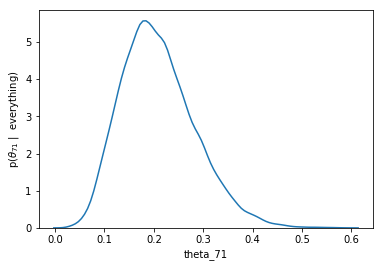

In [19]:
sns.kdeplot(post71)
plt.xlabel('theta_71')
plt.ylabel(r'p($\theta_{71}$ $\vert$  everything)');

In [20]:
y71 = sp.stats.binom.rvs(n=14,p=post71)

C:\Users\Shaan Desai\Anaconda3\envs\am207\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


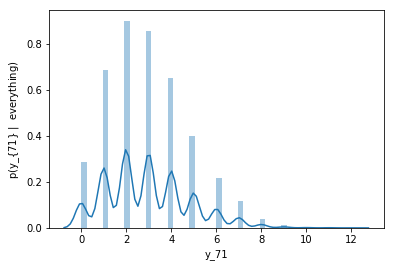

In [24]:
sns.distplot(y71)
plt.xlabel('y_71')
plt.ylabel(r'p(y_{71} $\vert$  everything)');

In [25]:
np.mean(y71)

2.9378